In [ ]:
!pip install matplotlib scipy pybullet

In [2]:
import pybullet as p
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

def cost(traj):
    sz = len(traj)
    l2 = np.sqrt(np.sum(traj ** 2 / sz))
    linf = np.max(np.abs(traj))
    return (l2, linf)

def symplectic_euler(func, x0, t):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        h = t[i] - t[i - 1]
        q_prev, p_prev = x[i - 1]
        p_next = p_prev + h * func([q_prev, p_prev], 0)[1]
        q_next = q_prev + h * p_next
        x[i] = [q_next, p_next]
    return x

def symplectic_euler_param(func, x0, t, a):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        h = t[i] - t[i - 1]
        q_prev, p_prev = x[i - 1]
        p_next = p_prev + h * func([q_prev, p_prev], 0, a)[1]
        q_next = q_prev + h * p_next
        x[i] = [q_next, p_next]
    return x

init a: [4.0]
l2_res: 8.782002014973198e-06
a: [4.00024071]


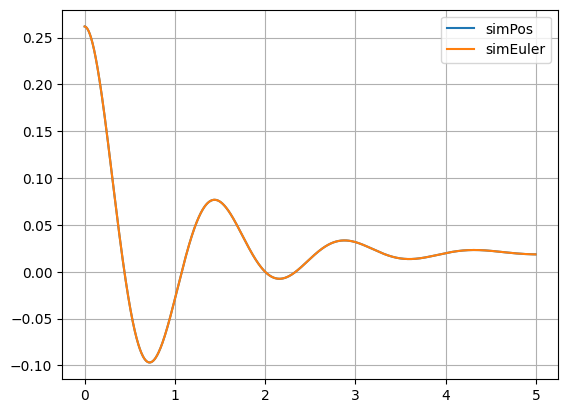

In [74]:
g = 10
L = 0.5
m = 1
damp = 0.5
force = 0.1
dt = 1/240 # pybullet simulation step
q0 = np.deg2rad(15)   # starting position (radian)
jIdx = 1
maxTime = 5
logTime = np.arange(0.0, maxTime, dt)
sz = len(logTime)
logPos = np.zeros(sz)
logPos[0] = q0
idx = 0

physicsClient = p.connect(p.DIRECT) # or p.DIRECT for non-graphical version
p.setGravity(0,0,-10)
boxId = p.loadURDF("./pendulum.urdf", useFixedBase=True)

# turn off internal damping
p.changeDynamics(boxId, 1, linearDamping=0, angularDamping=0)

# go to the starting position
p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, targetPosition=q0,
                        controlMode=p.POSITION_CONTROL)
for _ in range(100):
    p.stepSimulation()

# turn off the motor for the free motion
p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, targetVelocity=0,
                        controlMode=p.VELOCITY_CONTROL, force=0)
for t in logTime[1:]:
    p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx,
                            controlMode=p.TORQUE_CONTROL, force=0.1)
    p.stepSimulation()

    jointState = p.getJointState(boxId, jIdx)
    th1 = jointState[0]
    idx += 1
    logPos[idx] = th1

def rp(x, t):
    return [x[1],
            -g/L*np.sin(x[0]) - damp/(m*L**2)*x[1] + 1/(m*L**2)*force]

def rp_lin(x, t):
    return [x[1],
            -g/L*x[0] - damp/(m*L**2)*x[1] + 1/(m*L**2)*force]

def rp_param(x, t, a):
    return [x[1],
            -a*np.sin(x[0])]

def rp_param_damp(x, t, k):
    return [x[1],
            -g/L*np.sin(x[0]) - k*x[1]]

def rp_param_force(x, t, f):
    return [x[1],
            -g/L*np.sin(x[0]) - damp/(m*L**2)*x[1] + f*force]

def rp_param_general(x, t, list_params):
  return [x[1],
          -list_params[0]*np.sin(x[0]) - list_params[1]*x[1] + list_params[2]*force]

def rp_lin_upper(x, t):
  return [x[1],
          -g/L*np.sin(np.pi)-g/L*np.cos(np.pi)*(x[0]-np.pi) - damp/(m*L**2)*x[1] + 1/(m*L**2)*force]

# theta = odeint(rp, [q0, 0], logTime)
# logTheor = theta[:,0]

# (l2, linf) = cost(logPos - logTheor)
# print(l2, linf)

# theta = symplectic_euler(rp, [q0, 0], logTime)
# logEuler = theta[:, 0]

# (l2, linf) = cost(logPos - logEuler)
# print(l2, linf)

# thetaLin = symplectic_euler(rp_lin_upper, [q0, 0], logTime)
# logLin = thetaLin[:, 0]

def l2_cost(a):
    xx = symplectic_euler_param(rp_param_force, [q0, 0], logTime, a[0])
    return cost(logPos-xx[:,0])[0]

def l2_cost_general(a):
    xx = symplectic_euler_param(rp_param_general, [q0, 0], logTime, a)
    return cost(logPos-xx[:,0])[0]

def get_l2_optim_param(func, list_params):
  """
  input: list_params = [a - coeff before sinus,
                        k - coeff before dtheta,
                        f - coeff before force]
  return: list of optimal parameters
  """
  return minimize(l2_cost_general, list_params)

# k0 = [18, 2, 2]
# print(f'init k: {k0}')
# # res = minimize(l2_cost, k0)
# res = get_l2_optim_param(rp_param_general, k0)
# print(f'l2_res: {res.fun}')
# print(f'k: {res.x}')

# theta = symplectic_euler_param(rp_param_general, [q0, 0], logTime, res.x)
# logEuler = theta[:, 0]

# theta = symplectic_euler(rp, [q0, 0], logTime)
# logRP = theta[:, 0]

# print(f"l2_cost_rp: {cost(logPos - logRP)}")

a0 = [1/(m*L**2)]
print(f'init a: {a0}')
res = minimize(l2_cost, a0)
print(f'l2_res: {res.fun}')
print(f'a: {res.x}')
a = res.x[0]

theta = symplectic_euler_param(rp_param_force, [q0, 0], logTime, res.x[0])
logEuler = theta[:, 0]

import matplotlib.pyplot as plt

plt.grid(True)
plt.plot(logTime, logPos, label = "simPos")
# plt.plot(logTime, logRP, label = "simRP")
plt.plot(logTime, logEuler, label = "simEuler")
# plt.plot(logTime, logLin, label = "logLin")
plt.legend()

plt.show()

p.disconnect()

# 1 add damping to rp and rp_lin
# 2 add control torque to rp and rp_lin
# 3 widen minimize to estimate a, damping coef and toqrue coef
# 4 derive linear model from upper position and compare to sim (compare first 0.1 sec)